In [1]:
import cv2, glob
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from utils import white_black_ratio, image_colorfulness, box_area_to_total


# Lab 4 Basic Image Classification

## Team Pull-Push
Son, Bang, Annie

March 31, 2024


## Introduction

- One or two paragraphs providing an overview of the data set and the purpose of the report. Where did the data come from and what does it show? What questions are you trying to answer?

- One paragraph discussing the stakeholders in your data analysis and your ethical concerns or responsibilities using the data and in your analysis. Everyone has ethical considerations, no matter what the dataset or subject matter!

For our lab, we are analysing comics from *Calvin and Hobbes* to practice basic image classification. We are exploring wheter we can predich which panel includes which characters, specifically Calvin, Hobbes, both, or neither. Our dataset consists of 528 comic strips from Sunday publications, and metadata that includes information on the date of publication for each panel. Questions we are aiming to answer are, which features such as word count or colorfulness are good indicators of which charachters are present in the panel, and how accuratly we can predict that.

A major stakeholder in our analysis is Bill Watterson, the cartoonist behind *Calvin and Hobbes*, because we are analysing his illustrations. Other stakeholders include the publishers, newspapers, and anyone else involved in the production of the comic. These people are important to consider, because the comic is a part of their profession. We also recognize that the functions we are using to measure the different image features were written and provided to us by Dr. Lavin, and we do not take credit for his work.

## Data Exploration

- Import all images using `cv2.imread` function and append to a list in this section 
- Provide some details describing the images and the image data you have so far. What are the observations? What are the key variables you will be looking at? Are there any particular challenges in the data you will need to work through or be aware of during analysis?
- Using `plt.imshow` (as shown in my slides), display 3-4 PNG files in your Jupyter Notebook. Explain why you chose these images, and what you think they show.

In [2]:
meta=pd.read_csv('meta.csv')
meta.head()

,comic_id,pub_year,pub_month,pub_day,src_gif,src_png,panel_id,label
0,19851124,1985,11,24,source-gifs/19851124.gif,labeled-segments/both/19851124-14.png,14,both
1,19851124,1985,11,24,source-gifs/19851124.gif,labeled-segments/both/19851124-1.png,1,both
2,19851124,1985,11,24,source-gifs/19851124.gif,labeled-segments/both/19851124-2.png,2,both
3,19851124,1985,11,24,source-gifs/19851124.gif,labeled-segments/both/19851124-3.png,3,both
4,19851124,1985,11,24,source-gifs/19851124.gif,labeled-segments/both/19851124-7.png,7,both


In [3]:
def count_word_in_df(df):
    """
    This function takes a dataframe as input and returns the total number of words reported in the dataframe.
    """
    count=0
    for i in range(len(df)):
        count+=df['word_num'][i]
    return count

In [4]:
all_image=[]
word_count=[]
for src in meta['src_png']:
    file_id = src.split('/')[-1].split('.')[0]
    word_count.append(count_word_in_df(pd.read_csv('segment-term-counts/'+file_id+'.csv')))
    all_image.append(cv2.imread(src))
assert len(all_image) == len(word_count)

The images are a collection of gif files representing the Sunday comic strips for the comic Calvin and Hobbes. These files are short stories surronding Calvin, a boy with his stuff tiger Hobbes. These stories frequently involve other figures and characeters (mostly Hobbes' parents).

The image data is a dataset containing basic information about each single panel on every gif files (id of the gif file, year, month and date of the publication), the source path to the panel, and the label classifying the characters in the panel. We will use the source paths to access and load all the panels and the labels to train our models.

We pick 3 images: `19860914` with a lot of warm colors, `19860302` with the dominance of cool colors and `19860323` with mainly white background.

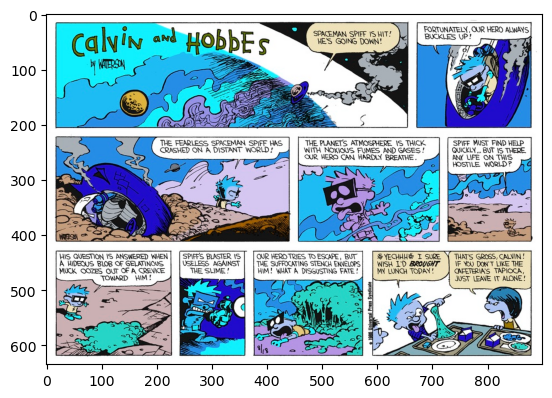

In [5]:
plt.imshow(cv2.imread('source-gifs/19860914.gif'))

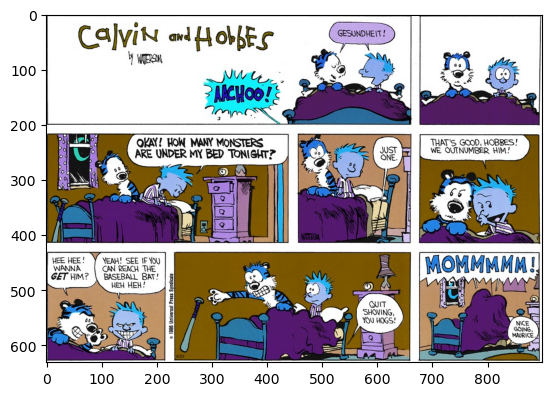

In [6]:
plt.imshow(cv2.imread('source-gifs/19860302.gif'))


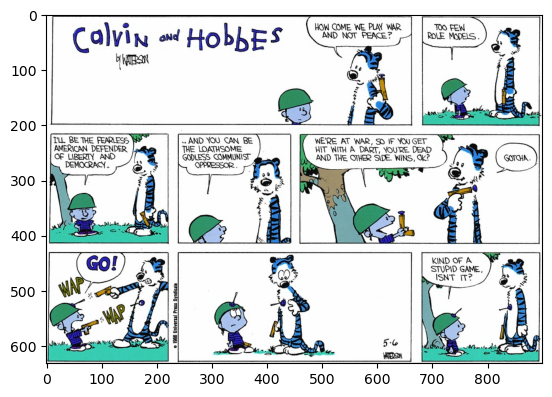

In [7]:
plt.imshow(cv2.imread('source-gifs/19860323.gif'))

## Code & Results

This section should include numerous chunks of python code with helpful annotations (comments and/or brief markdown cells after each chunk). Remember to print or return all results in your notebook so they display in the html file you output for the assignment. 

For this assignment in particular, make sure you have clearly marked code chunks performing the following:  

1. Calculate or derive, for each image in the dataset, a __white_pixels_ratio__, __box_area_to_total_area_ratio__, __colorfulness_score__, and __word_count__. The file `utils.py` includes functions to perform the first three of these. The fourth can be done with pandas operations. 

2. Using the labels in the metadata as your response variable and the scores about each image as predictors, train and test a KNN model that attempts to predict if an image contains Calvin, Hobbes, both, or neither. Follow our standard machine learning workflow (perform a train/test split, train model, generate predictions on test data, assess performance, and interpret results).

3. Instead of accuracy, use a confusion matrix, as well per-class precision and recall scores to evaluate model performance. (We will cover these in class this week.) 

4. Don't worry if the predictors don't perform very well.

5. Design a minimum of two additional metrics that you can generate or derive using `opencv` methods. Implement each idea by running a function on all images in the dataset and storing the result in your primary `DataFrame`

6. Use all generated/derived scores (including __white_pixels_ratio__, __box_area_to_total_area_ratio__, __colorfulness_score__, and __word_count__) to train, test, and evaluate a new KNN model. 

7. Choose any other classifier from scikit learn and repeat numbers 5 and 6 using that classifier. Alternatively, you can design a binary version of this classification task (Calvin vs. not calvin, Hobbes vs. not Hobbes, etc.) and train and test any scikit-learn model on this task. Feel free to label additional panels from the `no-label-segments` folder or change labels as you see fit.

In [8]:
white_ratio=[]
colorful_score=[]
box_area_ratio=[]
for im in all_image:
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    th, threshed = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
    white_ratio.append(white_black_ratio(threshed))
    colorful_score.append(image_colorfulness(im))
    edges = cv2.Canny(threshed, 100, 200)
    box_area_ratio.append(box_area_to_total(edges))

In [9]:
df=pd.DataFrame()
df['white_ratio']=white_ratio
df['colorful_score']=colorful_score
df['box_area_ratio']=box_area_ratio
df['word_count']=word_count

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df, meta['label'], test_size=0.3, shuffle=True, random_state=13)

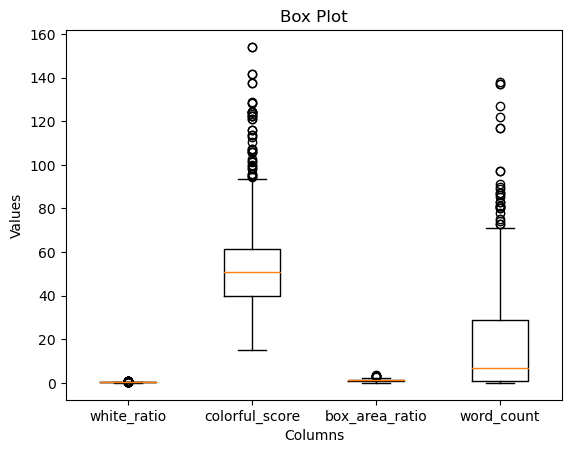

In [11]:
plt.boxplot(df.values)
plt.xticks(range(1, len(df.columns) + 1), df.columns)
plt.xlabel('Columns')
plt.ylabel('Values')
plt.title('Box Plot')
plt.show()


In machine learning, when features are on vastly different scales, algorithms that rely on distance calculations, such as K-Nearest Neighbors (KNN), may perform poorly. This is because KNN calculates the distance between different instances, and if one feature has a large range of values, it can dominate the distance calculations, effectively making the algorithm biased towards that particular feature.

To avoid this, it is common to standardize the data so that each feature contributes approximately proportionately to the final distance. After standardization, all features will have the same scale, and this allows the KNN algorithm to operate on a level playing field where each feature has an equal chance to influence the outcome. Without standardizing, the word_count feature, for example, might overwhelm the influence of white_ratio in the distance calculations due to its larger range of values.

In [12]:
# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Normalize the training data
X_train_normalized = scaler.transform(X_train)

# Normalize the test data
X_test_normalized = scaler.transform(X_test)

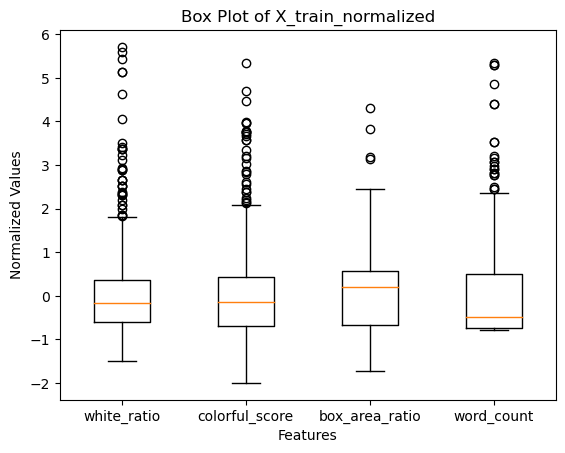

In [13]:
plt.boxplot(X_train_normalized)
plt.xlabel('Features')
plt.ylabel('Normalized Values')
plt.title('Box Plot of X_train_normalized')
plt.xticks(range(1, len(df.columns) + 1), df.columns)
plt.show()


In [15]:
labels=["calvin", "both", "hobbes", "other"]
labels = sorted(labels)

#### Tune the KNN

In [16]:
for k in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_normalized, y_train)
    predictions = knn.predict(X_test_normalized)
    print("k = ", k)
    print("Test accuracy: ", knn.score(X_test_normalized, y_test))
    print("Confusion matrix: ")
    report = classification_report(np.array(y_test.tolist()), predictions, target_names=labels)
    print(report)

k =  1
Test accuracy:  0.6566265060240963
Confusion matrix: 
              precision    recall  f1-score   support

        both       0.61      0.55      0.58        85
      calvin       0.67      0.75      0.71        87
      hobbes       0.54      0.33      0.41        42
       other       0.70      0.78      0.74       118

    accuracy                           0.66       332
   macro avg       0.63      0.60      0.61       332
weighted avg       0.65      0.66      0.65       332

k =  2
Test accuracy:  0.5150602409638554
Confusion matrix: 
              precision    recall  f1-score   support

        both       0.38      0.65      0.48        85
      calvin       0.54      0.64      0.59        87
      hobbes       0.57      0.19      0.29        42
       other       0.75      0.44      0.56       118

    accuracy                           0.52       332
   macro avg       0.56      0.48      0.48       332
weighted avg       0.58      0.52      0.51       332

k =  3
T

#### Final KNN

In [17]:
knn = KNeighborsClassifier(n_neighbors=1)
trained = knn.fit(X_train_normalized, y_train)
predictions = trained.predict(X_test_normalized)

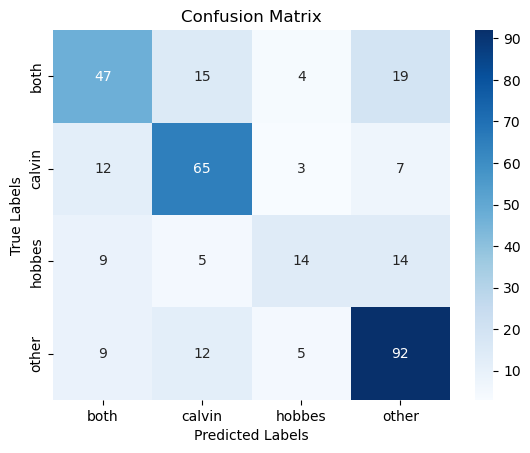

              precision    recall  f1-score   support

        both       0.61      0.55      0.58        85
      calvin       0.67      0.75      0.71        87
      hobbes       0.54      0.33      0.41        42
       other       0.70      0.78      0.74       118

    accuracy                           0.66       332
   macro avg       0.63      0.60      0.61       332
weighted avg       0.65      0.66      0.65       332



In [18]:

result_matrix = confusion_matrix(np.array(y_test.tolist()), predictions, labels=labels)
sns.heatmap(result_matrix, annot=True, cmap='Blues',xticklabels=labels, yticklabels=labels)
plt.xlabel('Predictions')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

report = classification_report(np.array(y_test.tolist()), predictions, target_names=labels)
print(report)


#### New KNN

In [26]:
import cv2
import numpy as np

def calculate_average_size(image):
    """
    Calculates the average size of objects in the given image.
    """
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to convert the image to binary
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculate the total area of all contours
    total_area = sum(cv2.contourArea(contour) for contour in contours)

    # Calculate the average size of objects
    average_size = total_area / len(contours)

    return average_size

# Function to calculate edge density
def calculate_edge_density(image):
    """
    Calculates the edge density of the given image.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edge_density = np.count_nonzero(edges) / (image.shape[0] * image.shape[1])
    return edge_density

average_sizes = []
edge_densities = []
# Iterate over each image in the dataset
for i, image in enumerate(all_image):    
    # Calculate average color
    average_size = calculate_average_size(image)
    
    # Calculate edge density
    edge_density = calculate_edge_density(image)
    
    # Store the results in the primary DataFrame
    average_sizes.append(average_size)
    edge_densities.append(edge_density)
df['average_size'] = average_sizes
df['edge_density'] = edge_densities
df.head()

,white_ratio,colorful_score,box_area_ratio,word_count,average_size,edge_density
0,0.325663,49.661179,0.665642,78,3288.043478,0.152010
1,0.233589,52.460633,1.933617,83,75582.000000,0.162663
2,0.233589,52.460633,1.933617,83,75582.000000,0.162663
3,0.218319,53.929820,0.000000,86,191.989474,0.153060
4,0.348711,46.617465,1.032311,1,71920.000000,0.155321


In [20]:
X_train, X_test, y_train, y_test = train_test_split(df, meta['label'], test_size=0.3, shuffle=True, random_state=13)

In [21]:
# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Normalize the training data
X_train_normalized = scaler.transform(X_train)

# Normalize the test data
X_test_normalized = scaler.transform(X_test)

Text(0.5, 1.0, 'Box Plot')

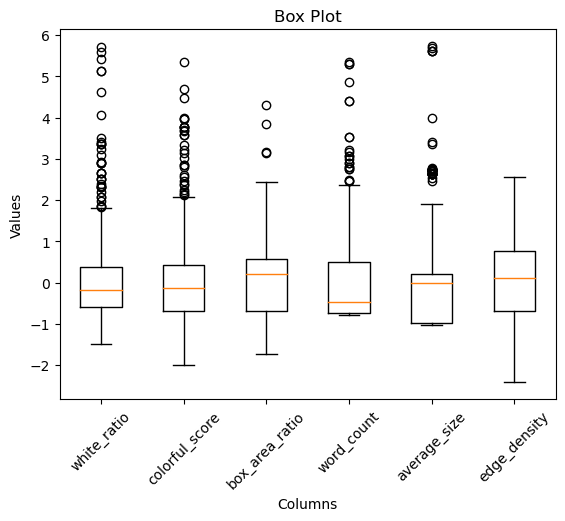

In [23]:
plt.boxplot(X_train_normalized)
plt.xticks(range(1, len(df.columns) + 1), df.columns,rotation=45)
plt.xlabel('Columns')
plt.ylabel('Values')
plt.title('Box Plot')

Test accuracy:  0.6596385542168675
Confusion matrix: 


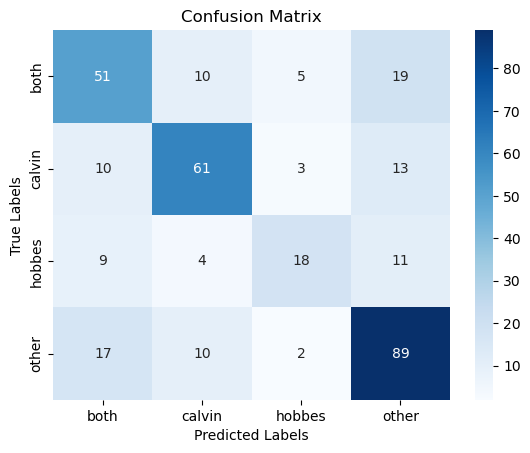

              precision    recall  f1-score   support

        both       0.59      0.60      0.59        85
      calvin       0.72      0.70      0.71        87
      hobbes       0.64      0.43      0.51        42
       other       0.67      0.75      0.71       118

    accuracy                           0.66       332
   macro avg       0.66      0.62      0.63       332
weighted avg       0.66      0.66      0.66       332



In [25]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_normalized, y_train)
predictions = knn.predict(X_test_normalized)
print("Test accuracy: ", knn.score(X_test_normalized, y_test))
print("Confusion matrix: ")
result_matrix = confusion_matrix(np.array(y_test.tolist()), predictions, labels=labels)
sns.heatmap(result_matrix, annot=True, cmap='Blues',xticklabels=labels, yticklabels=labels)
plt.xlabel('Predictions')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
report = classification_report(np.array(y_test.tolist()), predictions, target_names=labels)
print(report)

#### Support Vector Machine & Logistic Regression

In [42]:
# Convert y_train to binary values
y_train_binary = (y_train == 'calvin').astype(int)

# Convert y_test to binary values
y_test_binary = (y_test == 'calvin').astype(int)


In [43]:
from sklearn.svm import SVC

# Create an instance of the SVM classifier
svm_classifier = SVC()

# Train the classifier on the training data
svm_classifier.fit(X_train_normalized, y_train_binary)

# Predict the labels for the test data
y_pred = svm_classifier.predict(X_test_normalized)
report = classification_report(np.array(y_test_binary.tolist()), y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.95      0.89       245
           1       0.78      0.49      0.61        87

    accuracy                           0.83       332
   macro avg       0.81      0.72      0.75       332
weighted avg       0.83      0.83      0.82       332



In [44]:
from sklearn.linear_model import LogisticRegression

# Create an instance of the Logistic Regression classifier
classifier = LogisticRegression()

# Fit the classifier on the training data
classifier.fit(X_train_normalized, y_train_binary)

# Predict on the test data
y_pred = classifier.predict(X_test_normalized)
report = classification_report(np.array(y_test_binary.tolist()), y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.86      0.90      0.88       245
           1       0.67      0.57      0.62        87

    accuracy                           0.81       332
   macro avg       0.76      0.74      0.75       332
weighted avg       0.81      0.81      0.81       332



## Interpretation

Interpret your output, highlighting the key results and explaining the main takeaways. Make sure you address the following topics:

1. Your rationale for the use of the metrics you designed and implemented, including what aspect of the comics you were hoping to capture. (Note that the rationale here is more important than the metric itself... I will mostly be grading how you are thinking about this idea.)

2. Which, if any, features seem to be useful in the classification task? Did any of your ideas produce useful results? 

3. Performance, as measured by precision and recall. Impact of imbalanced classes. Differences in per-class performance. Rationale for your choice of model, and perceived impact of your model choice. Impact of binarizing, if applicable. 

4. Potential limits of the basic computer vision approaches used in this lab.

### Answers:

1. The rationale for using the edge density and average size of objects in the given image as metrics is to capture important visual characteristics of the comics.

    Edge Density: Edge density refers to the amount of edges or boundaries present in an image. By measuring the edge density, we can gain insights into the level of detail and complexity in each page of the comics. Higher edge density indicates more intricate and detailed images (or more text), while lower edge density suggests simpler and less detailed images. This measure is particularly useful in our analysis, as we've noted that images featuring Hobbes tend to exhibit a higher edge density compared to those centered around Calvin.

    Average Size of Objects: The average size of objects in the image provides information about the scale and prominence of different elements in the comics. This measure is particularly useful in our analysis, as we've noted that images featuring Hobbes tend to be larger compared to those centered around Calvin.

2. Our introduction of two additional metrics—Edge Density and Average Size of Objects—has significantly enhanced the KNN model's ability to accurately identify Hobbes. This improvement is underscored by the notable rise in the F1-Score for the Hobbes category, which increased from 0.41 to 0.51, and for the Both category, which saw a slight increase from 0.58 to 0.59.

3. 
    For the 'both' category, precision and recall are both at 0.59 and 0.60, respectively. This indicates a relatively balanced performance in terms of false positives and false negatives.

    For the 'calvin' category, precision is at 0.72 and recall at 0.70, which suggests that the model is quite reliable at predicting the 'calvin' category with fewer false positives and negatives.

    The 'hobbes' category shows a lower precision of 0.64 but a notably lower recall of 0.43. This suggests the model is more conservative in predicting 'hobbes' and is missing a fair number of 'hobbes' instances (higher false negative rate).

    The 'other' category has a precision of 0.67 and the highest recall at 0.75, indicating that while there may be some false positives, it's good at capturing most of the 'other' instances.

    **Impact of Imbalanced Classes**
    The 'hobbes' category, which has the lowest number of instances in test set (42), indicates it's underrepresented in the dataset. This imbalance often leads to poorer performance metrics for the minority class, as observed with the lower recall for 'hobbes.'
4. We acknowledge several limitations of our approach:

    **Generalization**: Basic models might not generalize well to unseen data, especially if the training data is not diverse enough. For example, most images in our train dataset have more than 5 comic frames, we expect that our trained model cannot generalize to image with only 1 comic frame.

    **Noise**: The quality of comic images in real-world applications can vary, especially in scanned versions of physical comics.
    
    **Variability in Art Style**: As we have discussed, we use Edge Density because Hobbes tend to exhibit a higher edge density. However, this characteristic is substantially influenced by the artist's unique style. Different illustrators may employ varying line weights and densities, which could affect the reliability of Edge Density as a distinguishing feature. Therefore, while Edge Density can be a useful metric, its efficacy is closely tied to the consistency of the author's artistic approach.

## Conclusion



Our analysis taught us how to use image features to classify images. By testing the accuracy of different models, we were able to see what lead to the most accurate results. An example of this is that models trained with edge denisty were more accurate for identifying charachters, specifically Hobbes, which means that for the *Calvin and Hobbes* comics, edge density is an important feature for classifying images. We also learned how to deal with imbalanced classes. There were a lot fewer panels with just Hobbes, which made identifying those panels more difficult. Inversely, the category with the most panels was the other charachter category, which made identifying these panels a little easier. 

A strength of this dataset was that all of these comics being the Sunday edition meant that they were in color. This allowed us to utilize the colorfulness score in our analysis. However, it would also be interesting to see if we would be able to classify the black and white panels with as high of an accuracy as with the colorful panels. This could be one future direction for analysis on a similar data set, and then compare results.

A strength of using KNN to classify the images is that we were able to look at all 4 categories of charachters. We also tried doing logisit regression, but this only allowed us to classify between Calvin and Not Calvin, which is not as interesting.

## References      

List all works cited and consulted. Use proper APA format. (Note that this assignment does not require outside sources, but all sources you draw upon must be given proper credit.)